1. check whether numeric features should be converted into object and vice versa

2. When we group certain levels of an object feature, check both train and test dataset, make sure we include all the scenarios.

3. when we handle missing values, sometimes N/A meaning 0. Check if that feature takes value '0' or 0, if not we could set to "No xxx". Make sure that if the feature already has value '0' or 0, we do not conflict that by using "No xxx" in fillna().

4. When we do exponential transformation, divide the number if necessary to make sure value is not too large. It may give us inf

5. Before generating dummy variables, check the levels in each object features and compare between train and test data.If test data have new levels for object features, try to see if they can be groupped with other levels. In the end, make sure train data have equal or more levels in object features than test data.  

6. After generating dummy variables, if test data do not have certain levels, we still need to generate those dummy variables and assign value as 0 to make the prediction work. 

In [170]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from scipy.stats import norm

from collections import defaultdict

from sklearn.preprocessing import StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Check basic stats

In [171]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [172]:
print(f"train's shape is", train.shape)
print("test's shape is ", test.shape)

train's shape is (1460, 81)
test's shape is  (1459, 80)


In [173]:
print("train has ", train.select_dtypes(include='number').shape[1], "numeric features")
print("train has ", train.select_dtypes(include='object').shape[1], "object features")
print("test has ", test.select_dtypes(include='number').shape[1], "numeric features")
print("test has ", test.select_dtypes(include='object').shape[1], "object features")

train has  38 numeric features
train has  43 object features
test has  37 numeric features
test has  43 object features


In [174]:
# Confirm SalePrice is missing in test data
df1 = train.select_dtypes(include='number')
df2 = test.select_dtypes(include='number')
both = list(df1.columns.intersection(df2.columns))
print("there are ",len(both)," numeric features exist in both train and test data")
print("Numeric feature ", list(df1.columns.difference(df2.columns)), " doesn't exist in test data")

there are  37  numeric features exist in both train and test data
Numeric feature  ['SalePrice']  doesn't exist in test data


In [175]:
# Confirm train and test have same object features
df1 = train.select_dtypes(include='object')
df2 = test.select_dtypes(include = 'object')
both = list(df1.columns.intersection(df2.columns))
print("there are ",len(both)," object features exist in both train and test data")

there are  43  object features exist in both train and test data


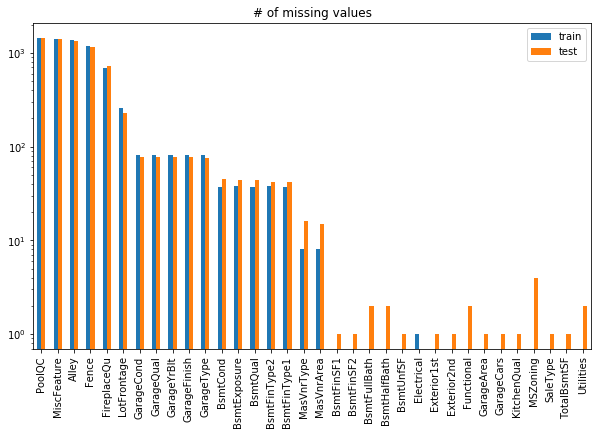

In [176]:
# check missing data in both train and test
s1 = train.isnull().sum().sort_values(ascending=False)
s1 = s1[s1>0]
s2 = test.isnull().sum().sort_values(ascending=False)
s2 = s2[s2>0]
df_missing = pd.concat([s1,s2], axis=1, keys=['train','test'])
df_missing['both'] = df_missing['train']+df_missing['test']
df_missing.sort_values('both', ascending=False)[['train','test']].plot(kind='bar', figsize=(10,6),\
                                                               title=('# of missing values'), logy=True)


In [177]:
df_missing

,train,test,both
Alley,1369.0,1352.0,2721.0
BsmtCond,37.0,45.0,82.0
BsmtExposure,38.0,44.0,82.0
BsmtFinSF1,NaN,1.0,NaN
BsmtFinSF2,NaN,1.0,NaN
BsmtFinType1,37.0,42.0,79.0
BsmtFinType2,38.0,42.0,80.0
BsmtFullBath,NaN,2.0,NaN
BsmtHalfBath,NaN,2.0,NaN
BsmtQual,37.0,44.0,81.0


In [178]:
# check numeric features see min, max, etc.
df = train.select_dtypes(include='number').describe()
df = df.transpose()
df


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


- Note: in the above result, some numeric variables only have a handful of levels, like GarageCars. Those variables need more work. We should group them and make them as object features. 

Skewness in train is 1.88


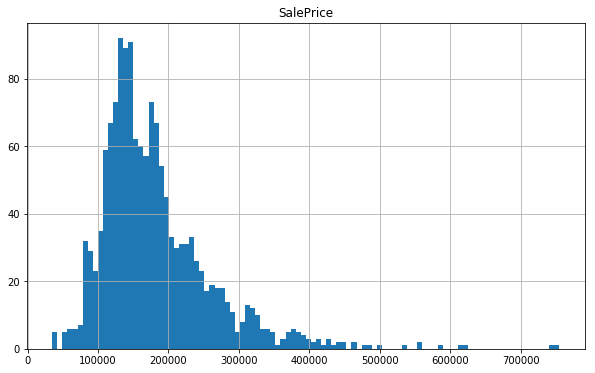

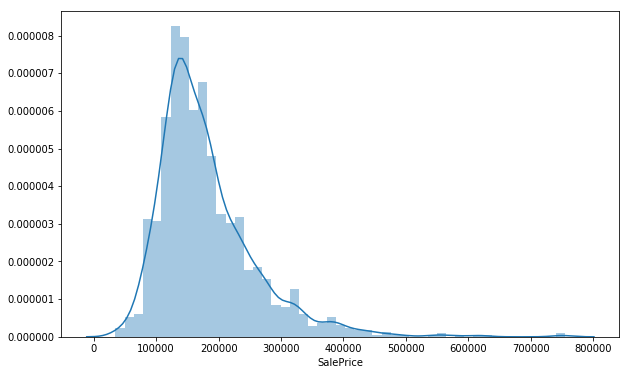

In [179]:
# check nomality of numeric features
train.hist('SalePrice',bins=100, figsize=(10,6))

plt.figure(figsize=(10,6))
sns.distplot(train['SalePrice'], kde=True)

#skewness and kurtosis
skew1 = train['SalePrice'].skew()
print("Skewness in train is %.2f" % skew1)


Text(0.5,1,'Probability Plot of Log(SalePrice+1)')

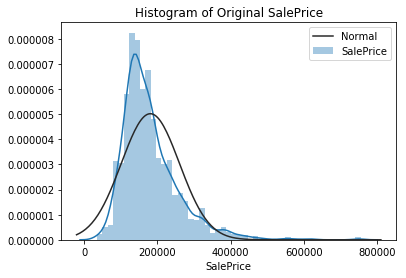

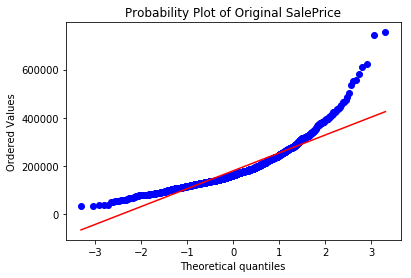

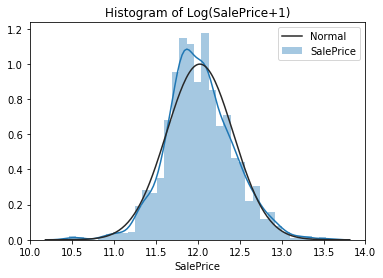

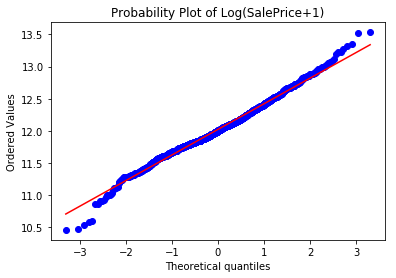

In [180]:
# log1p transformation on saleprice and check distribution
s1 = train['SalePrice']
s2 = np.log1p(train['SalePrice'])

sns.distplot(s1, fit=norm)
plt.title("Histogram of Original SalePrice")
plt.legend(['Normal','SalePrice',])

fig=plt.figure()
stats.probplot(s1,plot=plt)
plt.title("Probability Plot of Original SalePrice")

fig=plt.figure()
sns.distplot(s2, fit=norm)
plt.title("Histogram of Log(SalePrice+1)")
plt.legend(['Normal','SalePrice',])

fig=plt.figure()
stats.probplot(s2,plot=plt)
plt.title("Probability Plot of Log(SalePrice+1)")

There are 27 features need log transformation because their skewness > 0.5
['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'KitchenAbvGr', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'SalePrice', 'BsmtFinSF1', 'WoodDeckSF', 'TotalBsmtSF', 'MSSubClass', '1stFlrSF', 'GrLivArea', 'BsmtUnfSF', '2ndFlrSF', 'OverallCond', 'TotRmsAbvGrd', 'HalfBath', 'Fireplaces', 'BsmtFullBath']


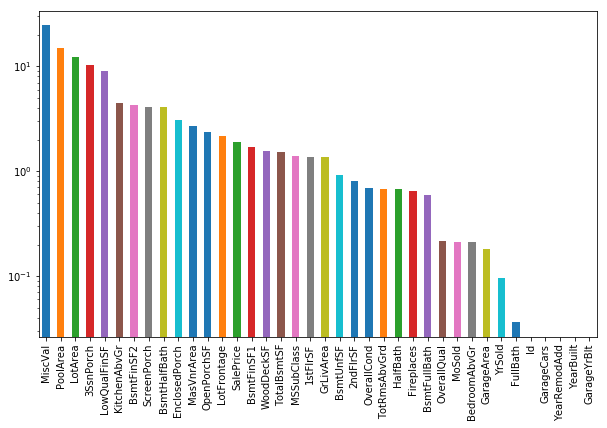

In [181]:
# calculate skewness across all numeric variables
s = train.select_dtypes(include='number').skew()
s = s.sort_values(ascending=False)
s.plot(kind='bar', logy=True, figsize=(10,6))
skew_cols = s[s>0.5].index
print("There are", len(skew_cols), "features need log transformation because their skewness > 0.5")
print(list(skew_cols))

In [182]:
# But before that let's check their min and max
df = pd.concat([train[skew_cols].min(),train[skew_cols].max()],keys=['min','max'],axis=1)
print(df)

                   min       max
MiscVal            0.0   15500.0
PoolArea           0.0     738.0
LotArea         1300.0  215245.0
3SsnPorch          0.0     508.0
LowQualFinSF       0.0     572.0
KitchenAbvGr       0.0       3.0
BsmtFinSF2         0.0    1474.0
ScreenPorch        0.0     480.0
BsmtHalfBath       0.0       2.0
EnclosedPorch      0.0     552.0
MasVnrArea         0.0    1600.0
OpenPorchSF        0.0     547.0
LotFrontage       21.0     313.0
SalePrice      34900.0  755000.0
BsmtFinSF1         0.0    5644.0
WoodDeckSF         0.0     857.0
TotalBsmtSF        0.0    6110.0
MSSubClass        20.0     190.0
1stFlrSF         334.0    4692.0
GrLivArea        334.0    5642.0
BsmtUnfSF          0.0    2336.0
2ndFlrSF           0.0    2065.0
OverallCond        1.0       9.0
TotRmsAbvGrd       2.0      14.0
HalfBath           0.0       2.0
Fireplaces         0.0       3.0
BsmtFullBath       0.0       3.0


- Need more investigation on variables have less than 10 levels. 

### Investigate numeric features with few unique values

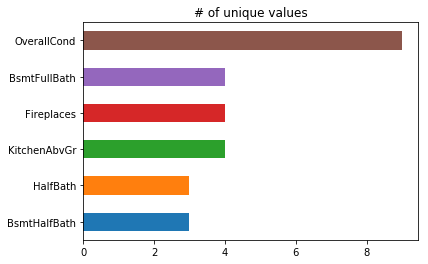

In [183]:
df = train[['KitchenAbvGr', 'BsmtHalfBath', 'OverallCond', 'HalfBath', 'Fireplaces', 'BsmtFullBath']]
df['HalfBath'].value_counts()
df.nunique().sort_values(ascending=True).plot('barh', title='# of unique values')

In [184]:
df = train[['SalePrice','KitchenAbvGr', 'BsmtHalfBath', 'OverallCond', 'HalfBath', 'Fireplaces', 'BsmtFullBath']]
df['log_SalePrice'] = np.log1p(df['SalePrice'])

def investigate_num_feature(var):
    print("The value_counts of HalfBath \n")
    print(df[var].value_counts().sort_index())

    print("\nThe mean SalePrice over HalfBath is: \n")
    print(df.groupby([var])['SalePrice'].apply(lambda x: x.mean()))

    plt.figure(figsize=(15,6))
    plt.subplot(1,3,1)
    sns.pointplot(x=var, y='SalePrice', data=df)
    plt.subplot(1,3,2)
    sns.pointplot(x=var, y='log_SalePrice', data=df)

    plt.subplot(1,3,3)
    sns.boxplot(x=var, y='SalePrice', data=df)
    

- ## KitenchAbvGr

The value_counts of HalfBath 

0       1
1    1392
2      65
3       2
Name: KitchenAbvGr, dtype: int64

The mean SalePrice over HalfBath is: 

KitchenAbvGr
0    127500.000000
1    183388.790230
2    131096.153846
3    109500.000000
Name: SalePrice, dtype: float64


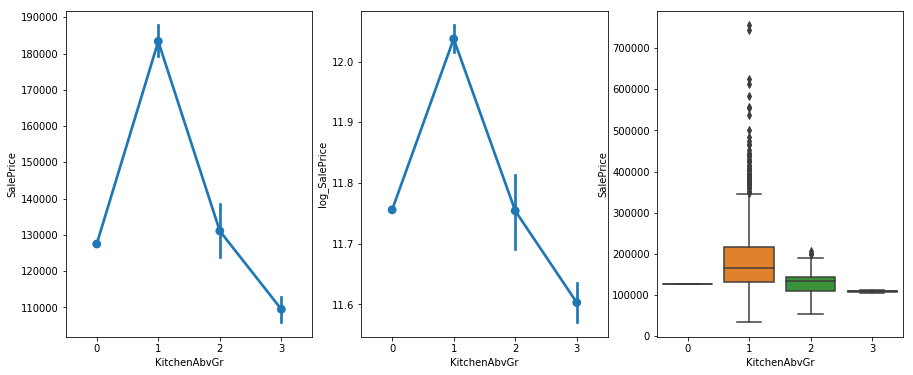

In [185]:
investigate_num_feature('KitchenAbvGr')
# we could group it as 1 and other

- ## BsmtHalfBath

In [186]:
print(train['BsmtHalfBath'].value_counts().sort_index())
print(test['BsmtHalfBath'].value_counts().sort_index())

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64
0.0    1364
1.0      91
2.0       2
Name: BsmtHalfBath, dtype: int64


The value_counts of HalfBath 

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

The mean SalePrice over HalfBath is: 

BsmtHalfBath
0    181230.330189
1    176098.125000
2    160850.500000
Name: SalePrice, dtype: float64


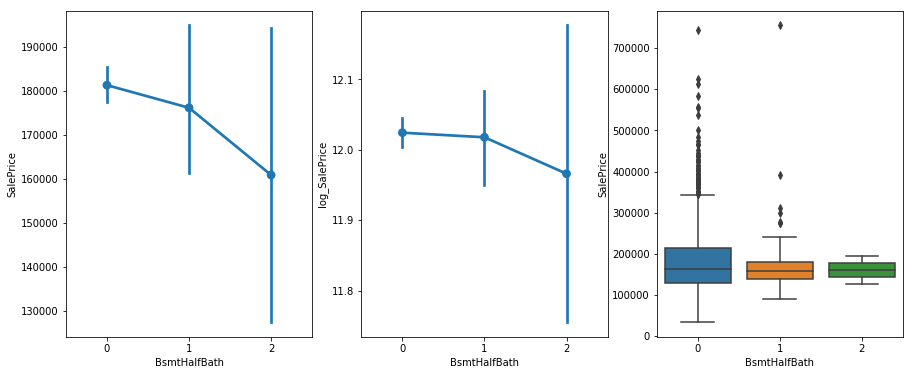

In [187]:
investigate_num_feature('BsmtHalfBath')
# we could group as 0 and other

- ## OverallCond

The value_counts of HalfBath 

1      1
2      5
3     25
4     57
5    821
6    252
7    205
8     72
9     22
Name: OverallCond, dtype: int64

The mean SalePrice over HalfBath is: 

OverallCond
1     61000.000000
2    141986.400000
3    101929.400000
4    120438.438596
5    203146.914738
6    153961.591270
7    158145.487805
8    155651.736111
9    216004.545455
Name: SalePrice, dtype: float64


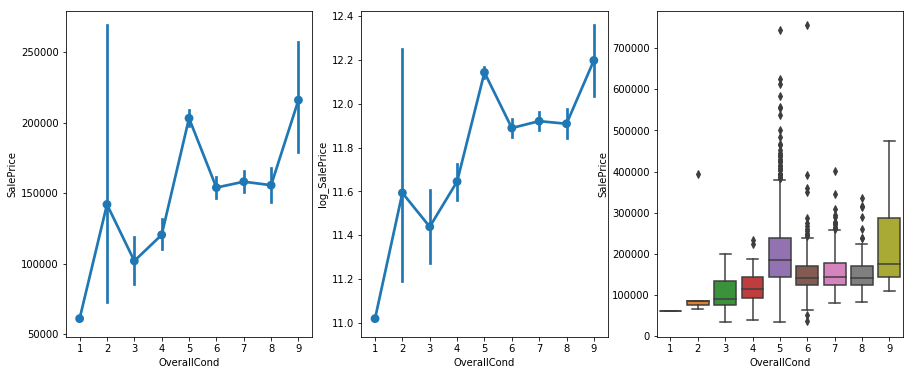

In [188]:
investigate_num_feature('OverallCond')
# we could group it as 1-4, 5, 6, 7, 8-9

- ## HalfBath

The value_counts of HalfBath 

0    913
1    535
2     12
Name: HalfBath, dtype: int64

The mean SalePrice over HalfBath is: 

HalfBath
0    162534.884995
1    212721.960748
2    162028.916667
Name: SalePrice, dtype: float64


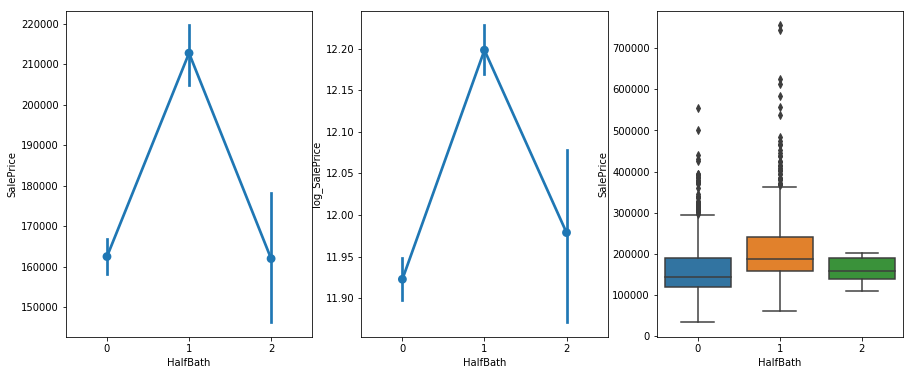

In [189]:
# log transformation makes the variance even bigger when HalfBath=2

# the boxplot makes the y axis has a wide spread such that it mislead the result somehow.
# By looking at boxplot, you may think HalfBath doesn't have much influence on SalePrice. But that's not right.
investigate_num_feature('HalfBath')

# we could group as 0, 1+

- ## Fireplaces: test data has more unique values than train data

In [190]:
print(train['Fireplaces'].value_counts().sort_index())
print(test['Fireplaces'].value_counts().sort_index())

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64
0    730
1    618
2    104
3      6
4      1
Name: Fireplaces, dtype: int64


The value_counts of HalfBath 

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

The mean SalePrice over HalfBath is: 

Fireplaces
0    141331.482609
1    211843.909231
2    240588.539130
3    252000.000000
Name: SalePrice, dtype: float64


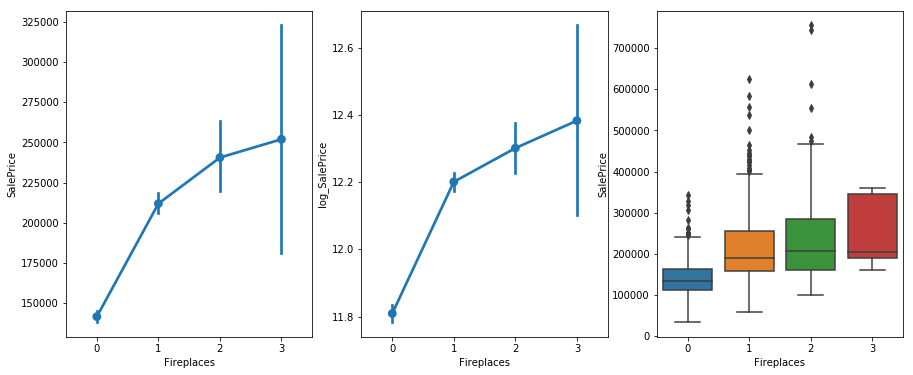

In [191]:
investigate_num_feature('Fireplaces')
# we could group 0, 1, 2+

- ## BsmtFullBath

The value_counts of HalfBath 

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

The mean SalePrice over HalfBath is: 

BsmtFullBath
0    165521.640187
1    202522.918367
2    213063.066667
3    179000.000000
Name: SalePrice, dtype: float64


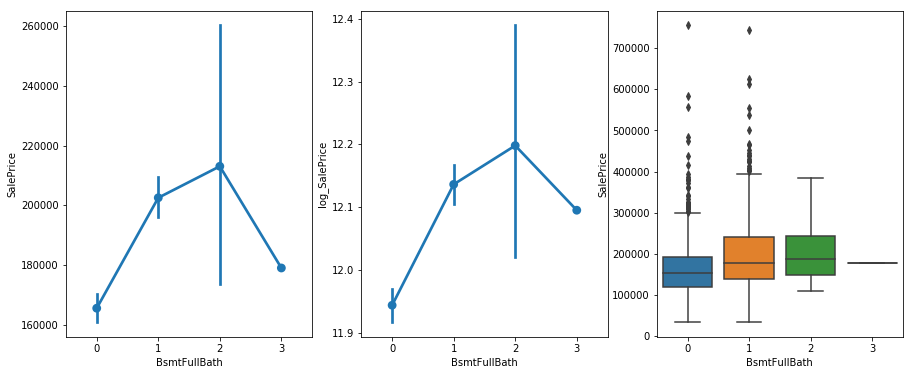

In [192]:
investigate_num_feature('BsmtFullBath')
# we could group as 0, 1+

# 3. Convert numeric into object - created train_proc and test_proc

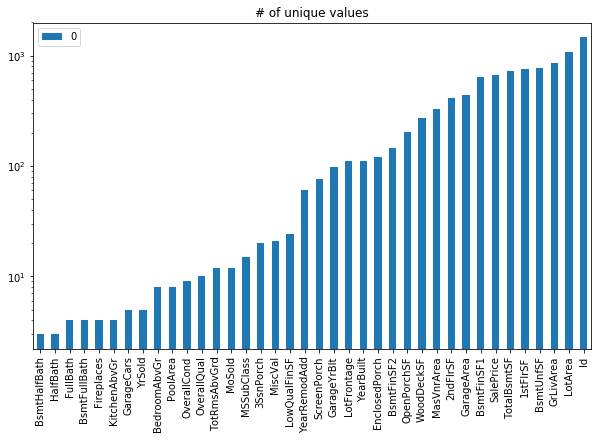

In [193]:
train.select_dtypes(include='number').nunique().sort_values()\
.to_frame().plot(kind='bar', logy=True, figsize=(10,6), title='# of unique values')

- 'KitchenAbvGr' - 1 and other
- 'BsmtHalfBath' - 0 and other
- 'OverallCond' - 1-4, 5, 6, 7, 8-9
- 'HalfBath' - 0, 1+
- 'Fireplaces' - 0,1,2+
- 'BsmtFullBath' - 0 and 1+

- MSSubClass is types
- MoSold is months

In [194]:
print(train['KitchenAbvGr'].value_counts().sort_index())

0       1
1    1392
2      65
3       2
Name: KitchenAbvGr, dtype: int64


In [195]:
train_proc = train.copy()

train_proc = train_proc.replace({
                            'KitchenAbvGr': {0:'other', 1:'1',2:'other',3:'other'},
                            'BsmtHalfBath': {0: '0', 1:'other',2:'other'},
                            'OverallCond': {1:'1-4',2:'1-4',3:'1-4',4:'1-4',5:'5',6:'6',7:'7',8:'8-9',9:'8-9'},
                            'HalfBath': {0:'0', 1:'1+', 2:'1+'},
                            'Fireplaces': {0:'0', 1:'1', 2:'2+', 3:'2+', 4:'2+'},
                            'BsmtFullBath': {0:'0', 1:'1+', 2:'1+', 3:'1+'},
                            "MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                             50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75",
                                             80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                             150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                            "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                            })

test_proc = test.copy()

test_proc = test_proc.replace({
                            'KitchenAbvGr': {0:'other', 1:'1',2:'other',3:'other'},
                            'BsmtHalfBath': {0: '0', 1:'other',2:'other'},
                            'OverallCond': {1:'1-4',2:'1-4',3:'1-4',4:'1-4',5:'5',6:'6',7:'7',8:'8-9',9:'8-9'},
                            'HalfBath': {0:'0', 1:'1+', 2:'1+'},
                            'Fireplaces': {0:'0', 1:'1', 2:'2+', 3:'2+', 4:'2+'},
                            'BsmtFullBath': {0:'0', 1:'1+', 2:'1+', 3:'1+'},
                            "MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                             50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75",
                                             80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                             150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                            "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                            })


In [196]:
n1 = len(train_proc.select_dtypes(include='number').columns)
n2 = len(test_proc.select_dtypes(include='number').columns)
print(f"there are {n1} numeric variables in train_proc")
print(f"there are {n2} numeric variables in test_proc")
# test_proc doesn't have saleprice

there are 30 numeric variables in train_proc
there are 29 numeric variables in test_proc


# 3. Convert Object into Ordinal

In [197]:
train_proc.select_dtypes(exclude='number').columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [198]:
## Below are the features have information in order
# 'ExterQual', 'ExterCond', 
# 'BsmtQual', 'BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinType2',
# 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
# 'GarageFinish', 'GarageQual', 'GarageCond',
# 'PoolQC','Fence'

# def convert_num_to_obj(df):
#     df = df.replace(
#         'Alley': {"Grvl":1,"Pave":2},
#     )

# 4. Handle missing values 

In [199]:
n_missing_cols = len(df_missing.index)
print(f"there are {n_missing_cols} features having missing values in train or test")

there are 34 features having missing values in train or test


In [200]:
missing_num_cols = train_proc[df_missing.index].select_dtypes(include='number').columns
print("there are ", len(missing_num_cols), " numeric features")
print("\n", missing_num_cols)

missing_obj_cols = train_proc[df_missing.index].select_dtypes(exclude='number').columns
print("\nthere are ", len(missing_obj_cols), " obj features")
print("\n", missing_obj_cols)


there are  9  numeric features

 Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'TotalBsmtSF'],
      dtype='object')

there are  25  obj features

 Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'Electrical', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'KitchenQual', 'MSZoning',
       'MasVnrType', 'MiscFeature', 'PoolQC', 'SaleType', 'Utilities'],
      dtype='object')


In [201]:
def get_max_occurence_value(df, var):
    d = defaultdict(int)
    for x in df[var]:
         d[x] += 1
    v = max(d.items(), key=lambda x: x[1])
    return v[0]

In [202]:
# max occurence value for object features below
Electrical_max_occur = get_max_occurence_value(train_proc, 'Electrical')
Exterior1st_max_occur = get_max_occurence_value(train_proc, 'Exterior1st')
Exterior2nd_max_occur = get_max_occurence_value(train_proc, 'Exterior2nd')
Functional_max_occur = get_max_occurence_value(train_proc, 'Functional')
KitchenQual_max_occur = get_max_occurence_value(train_proc, 'KitchenQual')
MSZoning_max_occur = get_max_occurence_value(train_proc, 'MSZoning')
MasVnrType_max_occur = get_max_occurence_value(train_proc, 'MasVnrType')
SaleType_max_occur = get_max_occurence_value(train_proc, 'SaleType')
Utilities_max_occur = get_max_occurence_value(train_proc, 'Utilities')

# numeric
GarageCars_max_occur = get_max_occurence_value(train_proc, 'GarageCars')
GarageYrBlt_max_occur = get_max_occurence_value(train_proc, 'GarageYrBlt')

In [203]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, GarageArea, LotFrontage and MasVnrArea
BsmtFinSF1_median = np.median(train_proc['BsmtFinSF1'].dropna())
BsmtFinSF2_median = np.median(train_proc['BsmtFinSF2'].dropna())
BsmtUnfSF_median = np.median(train_proc['BsmtUnfSF'].dropna())
TotalBsmtSF_median = np.median(train_proc['TotalBsmtSF'].dropna())
GarageArea_median = np.median(train_proc['GarageArea'].dropna())
LotFrontage_median = np.median(train_proc['LotFrontage'].dropna())
MasVnrArea_median = np.median(train_proc['MasVnrArea'].dropna())

In [204]:
def handle_missing(df):
    # --- Object Features ---- #
    # Alley : data description says NA means "no alley access"
    df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("None")
    
    # BsmtX object features: NA means no basement
    df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No Basement")
    df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No Basement")
    df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No Basement")
    df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No Basement")
    df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna("0")
    df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna("0")
    df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No Basement")
    
    # Electrical: fill in max occurence value
    df.loc[:, "Electrical"] = df.loc[:, "Electrical"].fillna(Electrical_max_occur)
    
    # Exterior1st & Exterior2nd:  fill in max occurence value
    df.loc[:, "Exterior1st"] = df.loc[:, "Exterior1st"].fillna(Exterior1st_max_occur)
    df.loc[:, "Exterior2nd"] = df.loc[:, "Exterior2nd"].fillna(Exterior2nd_max_occur)
    
    # Fence: NA means no fence
    df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No Fence")
    
    # FireplaceQu: NA means no fireplace
    df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No Fireplace")
    
    # Functional: fill in max occurence value
    df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna(Functional_max_occur)
    
    # GarageX: NA means no garage
    df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No Garage")
    df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No Garage")
    df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No Garage")
    df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No Garage")
    
    # KitchenQual: fill in max occurence value
    df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna(KitchenQual_max_occur)
    
    # MSZoning : fill in max occurence value
    df.loc[:, "MSZoning"] = df.loc[:, "MSZoning"].fillna(MSZoning_max_occur)
    
    # MasVnrType: fill in max occurence value
    df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna(MasVnrType_max_occur)
    
    # MiscFeature: NA mean "None"
    df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("None")
    
    # PoolQC
    df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No Pool")
    
    # SaleType: fill in max occurence value
    df.loc[:, "SaleType"] = df.loc[:, "SaleType"].fillna(SaleType_max_occur)
    
    # Utilities: fill in max occurence value
    df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna(Utilities_max_occur)
    
    # --- Numeric Features ---- #
    # BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 
    # GarageArea, LotFrontage, MasVnrArea: fill in median
    
    df.loc[:, "BsmtFinSF1"] = df.loc[:, "BsmtFinSF1"].fillna(BsmtFinSF1_median)
    df.loc[:, "BsmtFinSF2"] = df.loc[:, "BsmtFinSF2"].fillna(BsmtFinSF2_median)
    df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(BsmtUnfSF_median)
    df.loc[:, "TotalBsmtSF"] = df.loc[:, "TotalBsmtSF"].fillna(TotalBsmtSF_median)
    df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(GarageArea_median)
    df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(LotFrontage_median)
    df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(MasVnrArea_median)
    
    
    # GarageCars & GarageYrBlt: fill in max occurence value
    df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(GarageCars_max_occur)
    df.loc[:, "GarageYrBlt"] = df.loc[:, "GarageYrBlt"].fillna(GarageYrBlt_max_occur)


In [205]:
handle_missing(train_proc)
handle_missing(test_proc)

In [206]:
print(train_proc.isnull().any().any())
print(test_proc.isnull().any().any())

False
False


# 5. Log transformation on skewed numeric columns

There are 20 numeric features having skewness > 0.5. See below

['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'ScreenPorch', 'EnclosedPorch', 'MasVnrArea', 'LotFrontage', 'OpenPorchSF', 'SalePrice', 'BsmtFinSF1', 'WoodDeckSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtUnfSF', '2ndFlrSF', 'TotRmsAbvGrd']


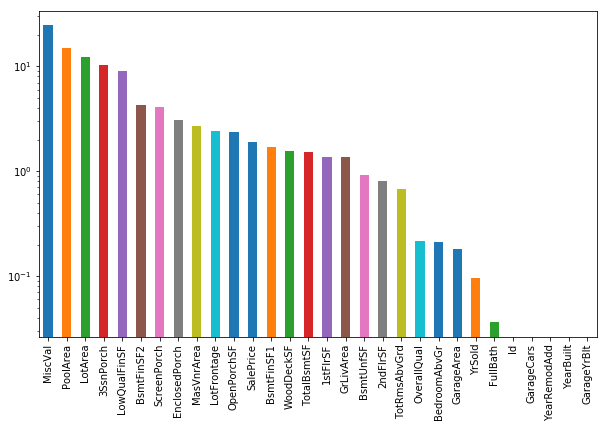

In [207]:
s = train_proc.select_dtypes(include='number').skew()
s = s.sort_values(ascending=False)
s.plot(kind='bar', logy=True, figsize=(10,6))
skew_cols = s[s>0.5].index
skew_list = list(skew_cols)
print("There are {} numeric features having skewness > 0.5. See below\n".format(len(skew_cols)))
print(skew_list)

### Log transformation on train_proc

In [208]:
# log1p transformation on train dataset
train_proc[skew_list] = np.log1p(train_proc[skew_list])
print(train_proc[skew_list].describe().transpose())

                count       mean       std        min        25%        50%  \
MiscVal        1460.0   0.233456  1.226030   0.000000   0.000000   0.000000   
PoolArea       1460.0   0.030431  0.438685   0.000000   0.000000   0.000000   
LotArea        1460.0   9.110966  0.517369   7.170888   8.929898   9.156887   
3SsnPorch      1460.0   0.085679  0.666876   0.000000   0.000000   0.000000   
LowQualFinSF   1460.0   0.099814  0.747354   0.000000   0.000000   0.000000   
BsmtFinSF2     1460.0   0.655398  1.845045   0.000000   0.000000   0.000000   
ScreenPorch    1460.0   0.410671  1.403194   0.000000   0.000000   0.000000   
EnclosedPorch  1460.0   0.698019  1.727317   0.000000   0.000000   0.000000   
MasVnrArea     1460.0   2.120264  2.628759   0.000000   0.000000   0.000000   
LotFrontage    1460.0   4.214451  0.314395   3.091042   4.110874   4.248495   
OpenPorchSF    1460.0   2.308541  2.152387   0.000000   0.000000   3.258097   
SalePrice      1460.0  12.024057  0.399449  10.46027

### Log transformation on test_proc

In [209]:
if 'SalePrice' in skew_list:
    print("Remove SalePrice in skew_list for test_proc dataset.")
    skew_list.remove('SalePrice')
#print(train_proc[skew_list].head(5))
test_proc[skew_list] = np.log1p(test_proc[skew_list])
print(train_proc[skew_list].describe().transpose())

Remove SalePrice in skew_list for test_proc dataset.
                count      mean       std       min       25%       50%  \
MiscVal        1460.0  0.233456  1.226030  0.000000  0.000000  0.000000   
PoolArea       1460.0  0.030431  0.438685  0.000000  0.000000  0.000000   
LotArea        1460.0  9.110966  0.517369  7.170888  8.929898  9.156887   
3SsnPorch      1460.0  0.085679  0.666876  0.000000  0.000000  0.000000   
LowQualFinSF   1460.0  0.099814  0.747354  0.000000  0.000000  0.000000   
BsmtFinSF2     1460.0  0.655398  1.845045  0.000000  0.000000  0.000000   
ScreenPorch    1460.0  0.410671  1.403194  0.000000  0.000000  0.000000   
EnclosedPorch  1460.0  0.698019  1.727317  0.000000  0.000000  0.000000   
MasVnrArea     1460.0  2.120264  2.628759  0.000000  0.000000  0.000000   
LotFrontage    1460.0  4.214451  0.314395  3.091042  4.110874  4.248495   
OpenPorchSF    1460.0  2.308541  2.152387  0.000000  0.000000  3.258097   
BsmtFinSF1     1460.0  4.229731  2.992052  0.00

In [210]:
s = train_proc[skew_list].skew()
print(s)

MiscVal           5.170704
PoolArea         14.363102
LotArea          -0.137404
3SsnPorch         7.734975
LowQualFinSF      7.460317
BsmtFinSF2        2.523694
ScreenPorch       3.150409
EnclosedPorch     2.112275
MasVnrArea        0.503532
LotFrontage      -0.870006
OpenPorchSF      -0.023397
BsmtFinSF1       -0.618410
WoodDeckSF        0.153537
TotalBsmtSF      -5.154670
1stFlrSF          0.080114
GrLivArea        -0.006140
BsmtUnfSF        -2.186504
2ndFlrSF          0.289643
TotRmsAbvGrd     -0.058258
dtype: float64


In [211]:
for i,var in enumerate(list(s.index)):
    print(i,var)

0 MiscVal
1 PoolArea
2 LotArea
3 3SsnPorch
4 LowQualFinSF
5 BsmtFinSF2
6 ScreenPorch
7 EnclosedPorch
8 MasVnrArea
9 LotFrontage
10 OpenPorchSF
11 BsmtFinSF1
12 WoodDeckSF
13 TotalBsmtSF
14 1stFlrSF
15 GrLivArea
16 BsmtUnfSF
17 2ndFlrSF
18 TotRmsAbvGrd


### After log1p transformation, there are are features having skewness>0.5, shown below. Needs to look into it.

In [212]:
# After log
s = s[s>0.5]
print("after log1p transformation, the followings still have skewness > 0.5")
print(s)

after log1p transformation, the followings still have skewness > 0.5
MiscVal           5.170704
PoolArea         14.363102
3SsnPorch         7.734975
LowQualFinSF      7.460317
BsmtFinSF2        2.523694
ScreenPorch       3.150409
EnclosedPorch     2.112275
MasVnrArea        0.503532
dtype: float64


### The histogram shows that they all have unimodal distribution, meaning one value dominates. Those features do not show much variability.

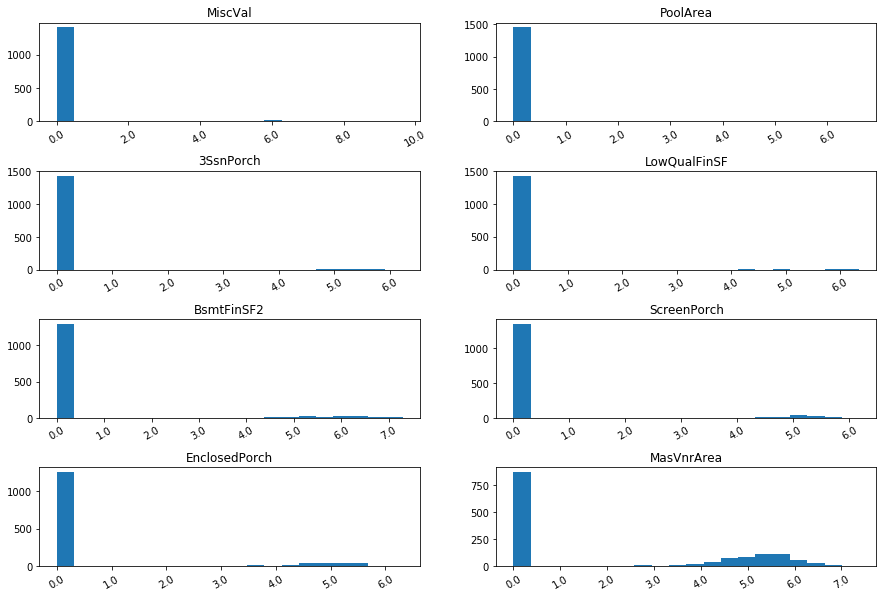

In [213]:
# the features having skewness > 0.5 after log1p has a unimodal distribution, needs to be dropped.
from matplotlib.ticker import FormatStrFormatter
from pylab import *

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
nplots = 8
ncol = 2
nrow = np.ceil(np.divide(nplots,ncol))

for i, var in enumerate(s.index):
    #print(i,var)
    ax = fig.add_subplot(nrow,ncol,i+1)
    vc = train_proc[var].value_counts().sort_index().to_frame()
#     sns.barplot(x=vc.index, y=vc[var], data=vc)
#     sns.distplot(train_proc[var], bins=20, kde=False)
    plt.hist(train_proc[var], bins=20, align='mid')                    # plt.hist is faster than sns.distplot
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.title(var)
    plt.xticks(rotation=30)
    

### Drop the features above as they do not show variability

In [214]:
# drop the features above from both train_proc and test_proc
drop_cols = list(s.index)
print("The features need to be dropped due to unimal distribution are: \n")
print(drop_cols)

print("\ntrain_proc has shape: ", train_proc.shape)
print("test_proc has shape: ", test_proc.shape)

train_proc = train_proc.drop(drop_cols, axis=1)
test_proc = test_proc.drop(drop_cols, axis=1)

print("after dropping those features, train_proc has shape: ", train_proc.shape)
print("after dropping those features, test_proc has shape: ", test_proc.shape)

The features need to be dropped due to unimal distribution are: 

['MiscVal', 'PoolArea', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'ScreenPorch', 'EnclosedPorch', 'MasVnrArea']

train_proc has shape:  (1460, 81)
test_proc has shape:  (1459, 80)
after dropping those features, train_proc has shape:  (1460, 73)
after dropping those features, test_proc has shape:  (1459, 72)


# 5. Generate additional numeric features

### The numeric features above include a few time features in years. They may not have linear relationship with SalePrice. Let's look into it a little more.

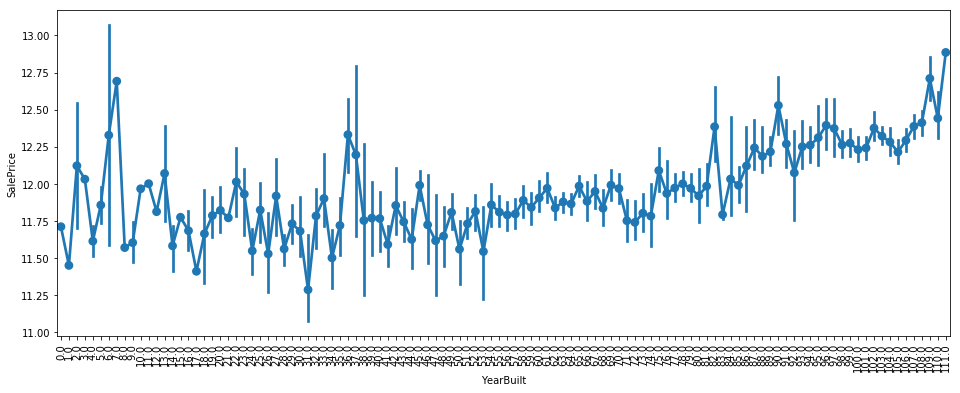

In [215]:
plt.figure(figsize=(16,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax = sns.pointplot(x='YearBuilt',y='SalePrice', data=train_proc)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.xticks(rotation=90)

df=train_proc[['SalePrice','YearBuilt']]
df = df.rename(columns={'SalePrice':'SalePrice_log'})
df['SalePrice'] = np.expm1(df['SalePrice_log'])
df['YearBuilt_sqrt'] = np.sqrt(np.divide(df['YearBuilt'],1000))
df['YearBuilt_sq'] = np.square(np.divide(df['YearBuilt'],1000))
df['YearBuilt_exp'] = np.exp(np.divide(df['YearBuilt'],1000))

In [216]:
train_proc['SalePrice'].max()

13.534474352733596

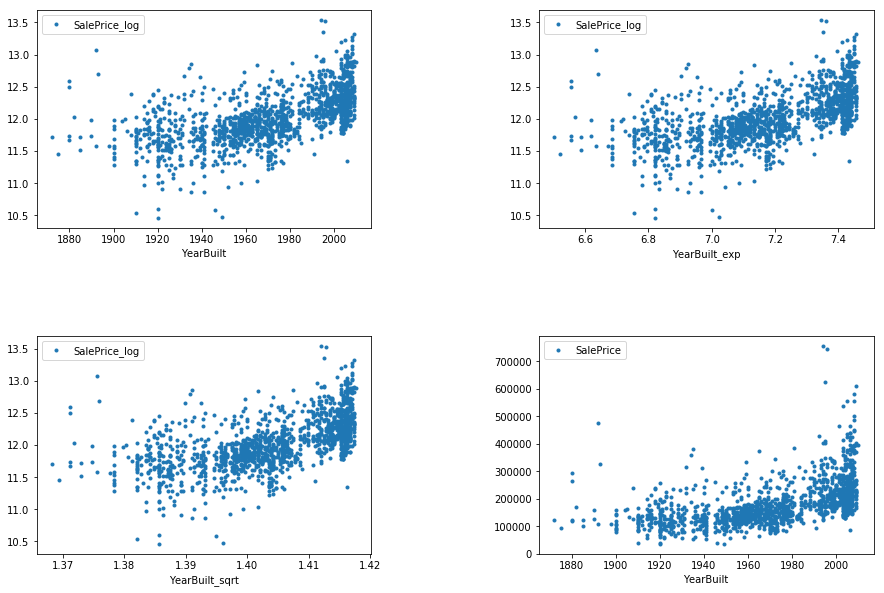

In [217]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

df = df.sort_values('YearBuilt') 
df.plot(x='YearBuilt',y='SalePrice_log',kind='line', style='.', ax=axes[0,0], figsize=(15,10))
df.plot(x='YearBuilt_exp',y='SalePrice_log',kind='line', style='.',ax=axes[0,1])
df.plot(x='YearBuilt_sqrt',y='SalePrice_log',kind='line', style='.', ax=axes[1,0])
df.plot(x='YearBuilt',y='SalePrice', style='.', ax=axes[1,1])

In [218]:
print(df.corr()['SalePrice_log'].sort_values(ascending=False))

SalePrice_log     1.000000
SalePrice         0.948374
YearBuilt_exp     0.590563
YearBuilt_sq      0.588640
YearBuilt         0.586570
YearBuilt_sqrt    0.585513
Name: SalePrice_log, dtype: float64


### Based on the correlation result, looks like YearBuilt_exp has slightly higher linear relationship with SalePrice_log.

In [219]:
list(train_proc.select_dtypes(include='number').columns)

['Id',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'YrSold',
 'SalePrice']

In [220]:
def gen_additional_num_features(df):
    df['YearBuilt_exp'] = np.exp(np.divide(df['YearBuilt'],1000))
    df['YearRemodAdd_exp'] = np.exp(np.divide(df['YearRemodAdd'],1000))
    df['GarageYrBlt_exp'] = np.exp(np.divide(df['GarageYrBlt'],1000))
    df['YrSold_exp'] = np.exp(np.divide(df['YrSold'],1000))

In [221]:
print(train_proc.shape)
print(test_proc.shape)
gen_additional_num_features(train_proc)
gen_additional_num_features(test_proc)
print(train_proc.shape)
print(test_proc.shape)

(1460, 73)
(1459, 72)
(1460, 77)
(1459, 76)


# 6. Standardize numeric data

In [222]:
print(train_proc.select_dtypes(include='number').describe().transpose()[['count','min','max','mean','std']])
print(test_proc.select_dtypes(include='number').describe().transpose()[['count','min','max','mean','std']])

                   count          min          max         mean         std
Id                1460.0     1.000000  1460.000000   730.500000  421.610009
LotFrontage       1460.0     3.091042     5.749393     4.214451    0.314395
LotArea           1460.0     7.170888    12.279537     9.110966    0.517369
OverallQual       1460.0     1.000000    10.000000     6.099315    1.382997
YearBuilt         1460.0  1872.000000  2010.000000  1971.267808   30.202904
YearRemodAdd      1460.0  1950.000000  2010.000000  1984.865753   20.645407
BsmtFinSF1        1460.0     0.000000     8.638525     4.229731    2.992052
BsmtUnfSF         1460.0     0.000000     7.756623     5.648378    1.854020
TotalBsmtSF       1460.0     0.000000     8.717846     6.750560    1.145712
1stFlrSF          1460.0     5.814131     8.453827     7.008452    0.317431
2ndFlrSF          1460.0     0.000000     7.633370     2.864586    3.293311
GrLivArea         1460.0     5.814131     8.638171     7.268512    0.333303
FullBath    

### Generate a list of numeric features for standardization

In [223]:
print(train_proc.shape)
print(test_proc.shape)

(1460, 77)
(1459, 76)


In [224]:
num_cols = list(train_proc.select_dtypes(include='number').columns)
#drop 'Id' 
num_cols.remove('Id')
num_cols.remove('SalePrice')
print("num_cols are features for standardization. We removed Id. The rest numeric features are: \n")
print(num_cols)


num_cols are features for standardization. We removed Id. The rest numeric features are: 

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'YrSold', 'YearBuilt_exp', 'YearRemodAdd_exp', 'GarageYrBlt_exp', 'YrSold_exp']


### Perform standardization on train_proc and test_proc
### Note that: in train_proc, standardization works on SalePrice. So we need to prepare a column for SalePrice with any value, otherwise it incurs error.
### I tried to do ss.transform on test_proc on the numeric features excluding SalePrice, it incurrs error too.

In [225]:
ss = StandardScaler()
train_proc[num_cols] = ss.fit_transform(train_proc[num_cols])

In [226]:
test_proc['SalePrice']=1
test_proc[num_cols] = ss.transform(test_proc[num_cols])

In [227]:
print(train_proc[num_cols].describe().transpose()[['count','min','max','mean','std']])

                   count       min       max          mean       std
LotFrontage       1460.0 -3.574462  4.883881  1.156229e-15  1.000343
LotArea           1460.0 -3.751177  6.126490 -1.936902e-15  1.000343
OverallQual       1460.0 -3.688413  2.821425 -7.680310e-17  1.000343
YearBuilt         1460.0 -3.287824  1.282839  1.032983e-15  1.000343
YearRemodAdd      1460.0 -1.689368  1.217843  4.518912e-15  1.000343
BsmtFinSF1        1460.0 -1.414140  1.474007 -1.809816e-17  1.000343
BsmtUnfSF         1460.0 -3.047600  1.137511  5.726393e-16  1.000343
TotalBsmtSF       1460.0 -5.894038  1.717673  1.087030e-16  1.000343
1stFlrSF          1460.0 -3.763749  4.554909  1.430629e-15  1.000343
2ndFlrSF          1460.0 -0.870117  1.448517  8.045315e-17  1.000343
GrLivArea         1460.0 -4.365036  4.110760  7.942657e-16  1.000343
FullBath          1460.0 -2.841822  2.605522  2.770995e-16  1.000343
BedroomAbvGr      1460.0 -3.514952  6.294997 -1.108892e-16  1.000343
TotRmsAbvGrd      1460.0 -4.182591

In [228]:
print(test_proc[num_cols].describe().transpose()[['count','min','max','mean','std']])
# SalePrice in test_proc are arbitrary numbers, don't pay attention!

                   count       min        max      mean       std
LotFrontage       1459.0 -3.574462   3.464517 -0.060888  1.040843
LotArea           1459.0 -3.513723   3.543783 -0.062091  0.970514
OverallQual       1459.0 -3.688413   2.821425 -0.014824  1.039268
YearBuilt         1459.0 -3.055978   1.282839  0.002980  1.006542
YearRemodAdd      1459.0 -1.689368   1.217843 -0.058288  1.023846
BsmtFinSF1        1459.0 -1.414140   1.359755 -0.001830  0.993268
BsmtUnfSF         1459.0 -3.047600   1.090249 -0.022718  1.013963
TotalBsmtSF       1459.0 -5.894038   1.559085 -0.030329  1.052503
1stFlrSF          1459.0 -3.142499   4.814531 -0.026899  1.033150
2ndFlrSF          1459.0 -0.870117   1.417101 -0.021271  0.990648
GrLivArea         1459.0 -3.773369   3.804748 -0.042089  0.948163
FullBath          1459.0 -2.841822   4.421303  0.010660  1.008103
BedroomAbvGr      1459.0 -3.514952   3.842510 -0.015241  1.017523
TotRmsAbvGrd      1459.0 -2.839362   3.633441 -0.069611  0.929150
GarageYrBl

### Take a look at correlation of all numeric features with SalePrice

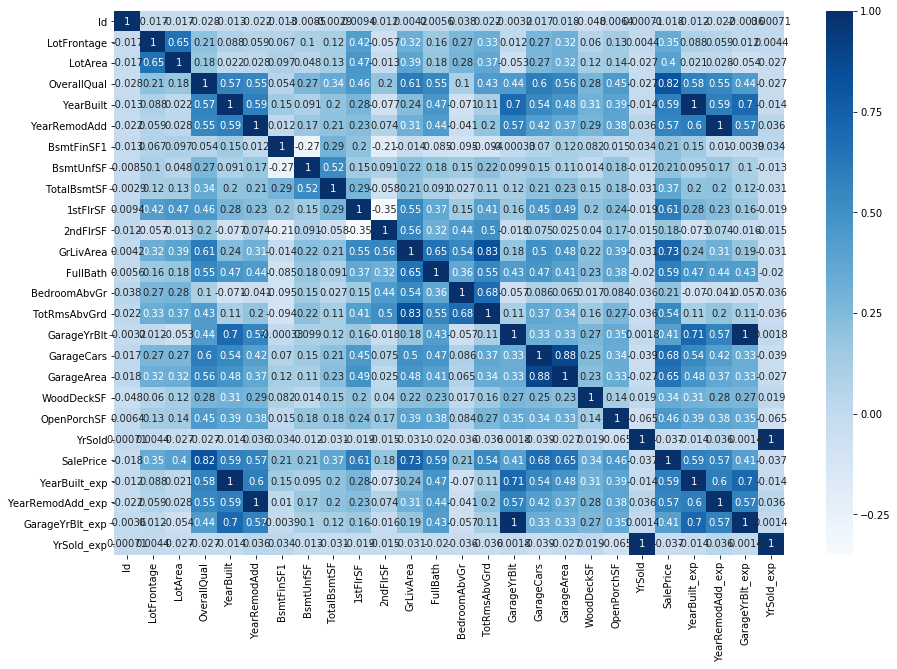

In [229]:
corr = train_proc.select_dtypes(include='number').corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr,cmap='Blues',annot=True)

# 7. Generate dummy variables for object features

In [230]:
print(train_proc.shape)
print(test_proc.shape)
l1 = list(train_proc.columns)
l2 = list(test_proc.columns)
print("The difference between columns in train_proc and test_proc is/are: \n")
print(list(set(l1)-set(l2)))

(1460, 77)
(1459, 77)
The difference between columns in train_proc and test_proc is/are: 

[]


In [231]:
obj_train = train_proc.select_dtypes(include='object')
obj_test = test_proc.select_dtypes(include='object')
nunique_df = pd.concat([obj_train.nunique(), obj_test.nunique()],keys=['train','test'], axis=1)
nunique_df['diff'] = nunique_df['train'] - nunique_df['test']
print("Below shows the # of unique values in each object features in train_proc and test_proc.")
print(nunique_df)

Below shows the # of unique values in each object features in train_proc and test_proc.
               train  test  diff
MSSubClass        15    16    -1
MSZoning           5     5     0
Street             2     2     0
Alley              3     3     0
LotShape           4     4     0
LandContour        4     4     0
Utilities          2     1     1
LotConfig          5     5     0
LandSlope          3     3     0
Neighborhood      25    25     0
Condition1         9     9     0
Condition2         8     5     3
BldgType           5     5     0
HouseStyle         8     7     1
OverallCond        5     5     0
RoofStyle          6     6     0
RoofMatl           8     4     4
Exterior1st       15    13     2
Exterior2nd       16    15     1
MasVnrType         4     4     0
ExterQual          4     4     0
ExterCond          5     5     0
Foundation         6     6     0
BsmtQual           5     5     0
BsmtCond           5     5     0
BsmtExposure       5     5     0
BsmtFinType1       7 

In [232]:
print("Below are the object features having different # of unique values between train_proc and test_proc")
print(nunique_df[nunique_df['diff']!=0])

Below are the object features having different # of unique values between train_proc and test_proc
             train  test  diff
MSSubClass      15    16    -1
Utilities        2     1     1
Condition2       8     5     3
HouseStyle       8     7     1
RoofMatl         8     4     4
Exterior1st     15    13     2
Exterior2nd     16    15     1
Heating          6     4     2
Electrical       5     4     1
GarageQual       6     5     1
PoolQC           4     3     1
MiscFeature      5     4     1


### Let's make sure the # of unique values in above object features are exatly same. 
### OTherwise the dummy variables will be off

In [233]:
def get_uniq_diff(var):
    vc1 = train_proc[var].value_counts()
    vc2 = test_proc[var].value_counts()
    vc = pd.concat([vc1,vc2],axis=1, keys=['train','test'])
    print(vc[vc.isnull().any(1)])

In [234]:
print(train_proc['BsmtFullBath'].value_counts())
print(test_proc['BsmtFullBath'].value_counts())

0     856
1+    604
Name: BsmtFullBath, dtype: int64
0     851
1+    608
Name: BsmtFullBath, dtype: int64


In [235]:
cols = list(nunique_df[nunique_df['diff']!=0].index)
print(cols)

for c in cols:
    print(c)
    get_uniq_diff(c)
    print("\n")


['MSSubClass', 'Utilities', 'Condition2', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Heating', 'Electrical', 'GarageQual', 'PoolQC', 'MiscFeature']
MSSubClass
       train  test
SC150    NaN     1


Utilities
        train  test
NoSeWa      1   NaN


Condition2
      train  test
RRAe      1   NaN
RRAn      1   NaN
RRNn      2   NaN


HouseStyle
        train  test
2.5Fin      8   NaN


RoofMatl
         train  test
ClyTile      1   NaN
Membran      1   NaN
Metal        1   NaN
Roll         1   NaN


Exterior1st
         train  test
ImStucc      1   NaN
Stone        2   NaN


Exterior2nd
       train  test
Other      1   NaN


Heating
       train  test
Floor      1   NaN
OthW       2   NaN


Electrical
     train  test
Mix      1   NaN


GarageQual
    train  test
Ex      3   NaN


PoolQC
    train  test
Fa      2   NaN


MiscFeature
      train  test
TenC      1   NaN




- MSSubClass: train_proc doesn't have SC150. Let's replace SC150 in test_proc with max occurence value
- Fireplaces: value 4 will be replaced into 2+

In [236]:
MSSubClass_max_occur = get_max_occurence_value(train_proc, 'MSSubClass')
print("The max occurence value is", MSSubClass_max_occur)

The max occurence value is SC20


In [237]:
test_proc = test_proc.replace({'MSSubClass': {'SC150':'SC20'}})

In [238]:
train_proc = pd.get_dummies(train_proc, drop_first=True)
test_proc = pd.get_dummies(test_proc, drop_first=True)
print(train_proc.shape)
print(test_proc.shape)

(1460, 284)
(1459, 266)


In [239]:
# method 1 to see the difference in two lists
# l1 = list(train_proc.columns)
# l2 = list(test_proc.columns)
# diff_list = []
# n = 0
# for i in l1:
#     if i not in l2:
#         diff_list.append(i)
        
# method 2 to see the difference in two lists
diff_list = list(set(train_proc.columns) - set(test_proc.columns))

print(diff_list)
print(len(diff_list))

['Utilities_NoSeWa', 'Electrical_Mix', 'RoofMatl_Membran', 'Condition2_RRAe', 'GarageQual_Fa', 'Condition2_RRAn', 'Exterior2nd_Other', 'MiscFeature_TenC', 'Heating_OthW', 'PoolQC_Fa', 'HouseStyle_2.5Fin', 'RoofMatl_Metal', 'Exterior1st_ImStucc', 'Condition2_RRNn', 'Exterior1st_Stone', 'Heating_GasA', 'RoofMatl_Roll', 'RoofMatl_CompShg']
18


In [240]:
for i in diff_list:
    test_proc[i] = 0
    
print(list(set(train_proc.columns) - set(test_proc.columns)))

[]


In [241]:
print(train_proc.columns.to_series().shape)
print(test_proc.columns.to_series().shape)

(284,)
(284,)


In [242]:
train_proc.SalePrice.describe()

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

# 8. Generate external data

In [243]:
print(train_proc.shape)
print(test_proc.shape)

(1460, 284)
(1459, 284)


In [251]:
# train_proc.to_csv("train_proc.csv",sep=',',index=False)
# test_proc.to_csv("test_proc.csv",sep=',', index=False)

In [245]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

In [246]:
y = train_proc['SalePrice']
train_model = train_proc.copy()
train_model = train_model.drop(['SalePrice'], axis=1)

print(train_model.shape)
print(y.shape)

(1460, 283)
(1460,)


In [247]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train_model, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 283)
X_test : (438, 283)
y_train : (1022,)
y_test : (438,)


In [248]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [249]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [250]:
# Look at predictions on training and validation set
print("RMSE on Training set : ", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

RMSE on Training set :  0.13612152915603998
RMSE on Test set : 0.1981461640741859
